# 1. Introdução


Este projeto tem o objetivo de estudar a implementação de redes neurais convolucionais (CNN) para a classificação de imagens do conjunto de dados EMNIST balanced.

https://www.kaggle.com/crawford/emnist

https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6/comments

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#importando as bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

# 2. Preparação dos dados

## 2.1 Carregando

In [ ]:
train = pd.read_csv("./assets/dataset/emnist_balanced_train.csv")
test = pd.read_csv("./assets/dataset/emnist_balanced_test.csv")

In [ ]:
#informações do treino
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112799 entries, 0 to 112798
Columns: 785 entries, 45 to 0.533
dtypes: int64(785)
memory usage: 675.6 MB


In [ ]:
#informações do teste
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18799 entries, 0 to 18798
Columns: 785 entries, 41 to 0.532
dtypes: int64(785)
memory usage: 112.6 MB


In [ ]:
train = train.sort_values(by=['45'])
test = test.sort_values(by=['41'])

Y_train = train["45"]
X_train = train.drop(labels=["45"], axis=1)

Y_test = test["41"]
X_test = test.drop(labels=["41"], axis=1) 

#liberando espaco
# del train
# del test

## 2.2 Analisando

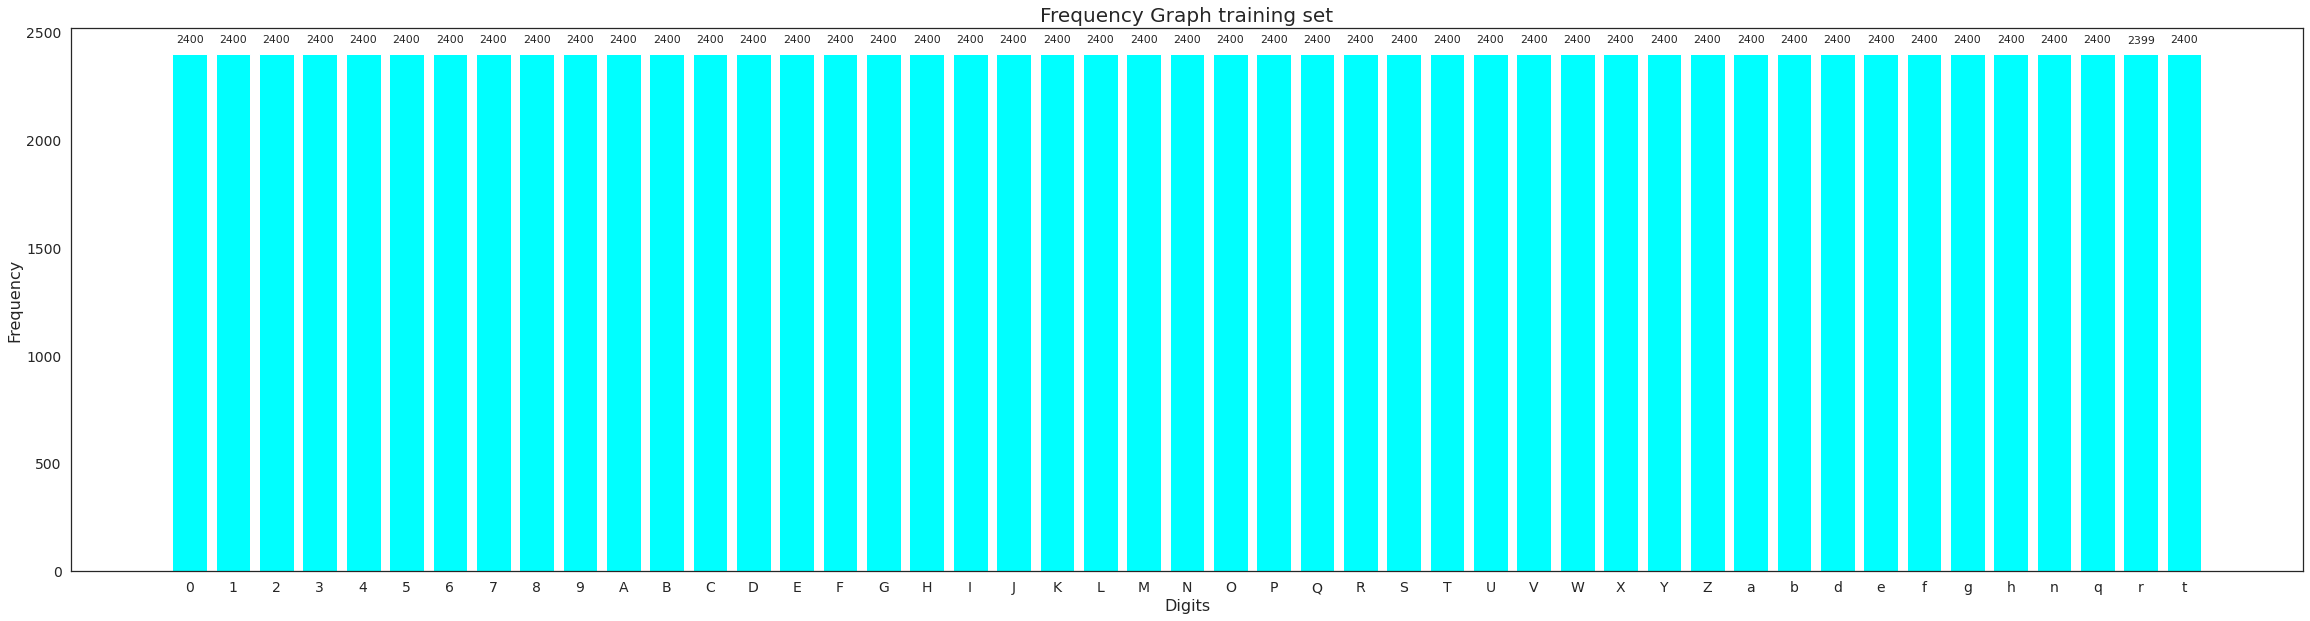

In [ ]:
counts = Y_train.value_counts().sort_index()
f = plt.figure(figsize=(40,10))
f.add_subplot(111)

plt.bar(counts.index,counts.values,width=0.8,color="cyan") #definindo o grafico

for i in counts.index: #printando os valores exatos em cada barra
    plt.text(i,counts.values[i]+50,str(counts.values[i]),horizontalalignment='center',fontsize=11)

labels = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt'

plt.tick_params(labelsize = 14)
plt.xticks(counts.index, labels)
plt.xlabel("Digits",fontsize=16)
plt.ylabel("Frequency",fontsize=16)
plt.title("Frequency Graph training set",fontsize=20) 
plt.show()

## 2.2 Normalizando

Realizamos uma normalização para reduzir o efeito das diferenças de iluminação. Além de que o CNN converge mais rapidamente nos dados normalizados

In [ ]:
# Normalize the data
X_train = X_train/255.0
X_test = X_test/255.0

## 2.3 Remodelando

### 2.3.1 Imagens

As imagens foram carregadas como um vetor de 784 valores, para facilitar o trabalho e a visualização, podemos remodela-los como matrizes 28x28

In [ ]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

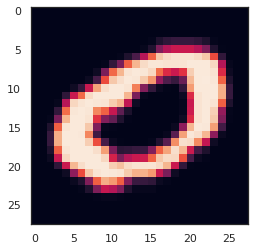

In [ ]:
plt.imshow(X_train[600][:,:,0])

### 2.3.2 Labels

Os rotulos são valores de 0 a 47, porém podemos codifica-los utilizando o one hot, essa codificação permite que a representação dos dados seja mais expressiva. Nela o número 1 representa o valor afirmativo e o 0 negativo.

In [ ]:
Y_train = to_categorical(Y_train, num_classes=47)
Y_test = to_categorical(Y_test, num_classes=47)

## 2.4 Dividir o treinamento e o conjunto de validação

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=2)

Utilizamos 80% para o treino e 20% para a validação

# 3. Modelo (CNN)

## 3.1 Definindo

In [ ]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5),padding='Same', activation='relu', input_shape=(28,28,1))) #Aplicando a convolucao de kernel 5x5 que recebe uma imagem 28x28 e utiliza a funcao de ativacao relu
model.add(Conv2D(filters=32, kernel_size=(5,5),padding='Same', activation='relu')) #Aplicando a convolucao de kernel 5x5 que recebe uma imagem 28x28 e utiliza a funcao de ativacao relu
model.add(MaxPool2D(pool_size=(2,2))) #Aplicano o pooling de tamanho 2x2
model.add(Dropout(0.25)) #Desligando 25% de neuronios para evitar o overfitting

model.add(Conv2D(filters=64, kernel_size=(3,3),padding='Same', activation='relu')) #Aplicando a convolucao de kernel 5x5 que recebe uma imagem 28x28 e utiliza a funcao de ativacao relu
model.add(Conv2D(filters=64, kernel_size=(3,3),padding='Same', activation='relu')) #Aplicando a convolucao de kernel 5x5 que recebe uma imagem 28x28 e utiliza a funcao de ativacao relu
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2))) #Aplicano o pooling de tamanho 2x2
model.add(Dropout(0.25)) #Desligando 25% de neuronios para evitar o overfitting


model.add(Flatten()) #Converte os resultados em vetores, para ser lido pela camda densa
model.add(Dense(256, activation="relu")) #adicionano a camada densamente conectada
model.add(Dropout(0.5)) #Desligando 5% de neuronios para evitar o overfitting
model.add(Dense(47, activation="softmax"))

In [ ]:
model.summary() #printado um sumario do modelo

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                        

In [ ]:
# Define the optimizer
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [ ]:
# Compile the model
model.compile(optimizer=optimizer , loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
epochs = 3
batch_size = 86

## 3.1 Treinando

In [ ]:
#treinando o modelo
history = model.fit(X_train,Y_train, epochs=epochs, validation_data=(X_val,Y_val), verbose=2)

#salvando o modelo que ja foi treinando
model.save('/content/drive/MyDrive/UNB/4° SEMESTRE (EaD)/EIA - Estudos em inteligência artificial/Projeto/Notebook/my_first_model.h5')

# from keras.models import load_model
# model = load_model('/content/drive/MyDrive/UNB/4° SEMESTRE (EaD)/EIA - Estudos em inteligência artificial/Projeto/Notebook/my_first_model.h5')

Epoch 1/3
2820/2820 - 661s - loss: 0.8301 - accuracy: 0.7449 - val_loss: 0.3995 - val_accuracy: 0.8617 - 661s/epoch - 234ms/step
Epoch 2/3
2820/2820 - 655s - loss: 0.5001 - accuracy: 0.8376 - val_loss: 0.3694 - val_accuracy: 0.8772 - 655s/epoch - 232ms/step
Epoch 3/3
2820/2820 - 657s - loss: 0.4985 - accuracy: 0.8415 - val_loss: 0.3896 - val_accuracy: 0.8693 - 657s/epoch - 233ms/step


In [ ]:
# plot accuracy and loss
def plotgraph(epochs, acc, val_acc, ylabel):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model accuracy')
    plt.ylabel(ylabel)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

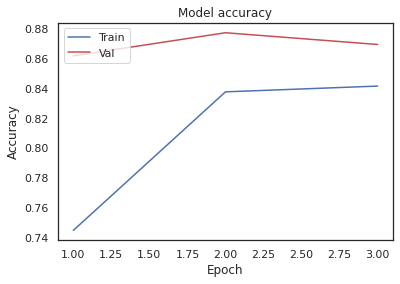

In [ ]:
# Accuracy curve

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1,len(acc)+1)

plotgraph(epochs, acc, val_acc, ylabel="Accuracy")

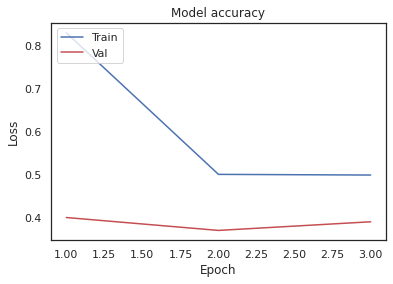

In [ ]:
# loss curve

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

plotgraph(epochs, loss, val_loss, ylabel="Loss")

# 4. Analisando os resultados

## 4.1 Validação

In [ ]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    labels = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt'

    plt.figure(figsize=(30,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

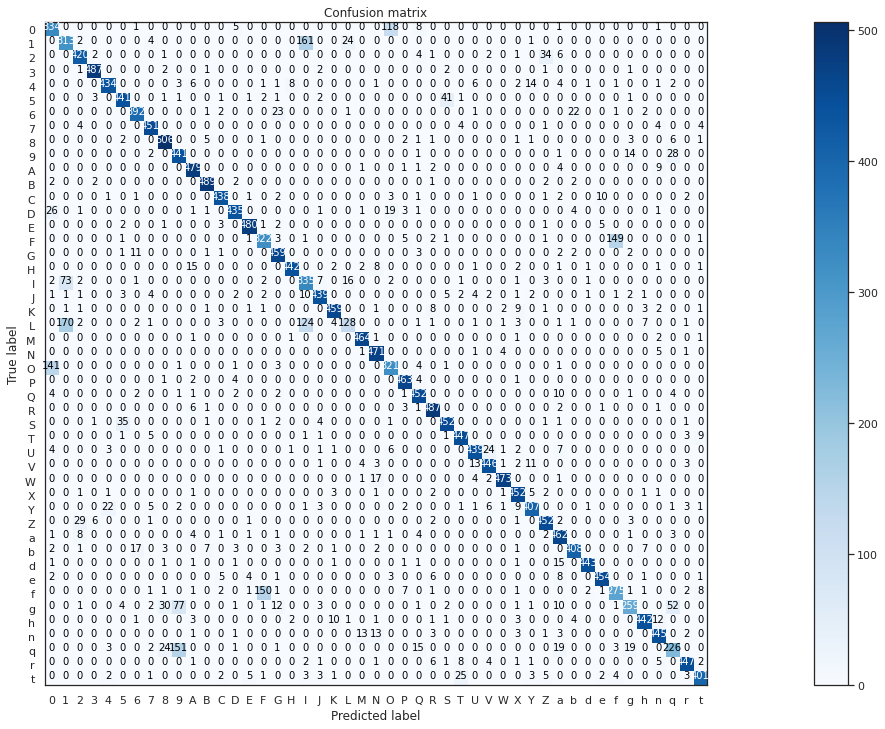

In [ ]:
Y_pred = model.predict(X_val) # prevendo os valores do conjunto de dados de validação
Y_pred_classes = np.argmax(Y_pred,axis=1)
Y_true = np.argmax(Y_val,axis=1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) #calculando a matriz de confusão
plot_confusion_matrix(confusion_mtx, classes=range(47)) #mostrando a matriz de confusão

In [ ]:
print(classification_report(Y_true, Y_pred_classes, target_names='0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt'))

              precision    recall  f1-score   support

           0       0.64      0.71      0.68       468
           1       0.56      0.62      0.59       505
           2       0.89      0.89      0.89       471
           3       0.97      0.98      0.98       497
           4       0.93      0.89      0.91       485
           5       0.90      0.89      0.89       496
           6       0.92      0.88      0.90       445
           7       0.94      0.96      0.95       468
           8       0.89      0.95      0.92       530
           9       0.65      0.91      0.76       487
           A       0.92      0.96      0.94       497
           B       0.96      0.98      0.97       500
           C       0.95      0.95      0.95       463
           D       0.95      0.88      0.91       494
           E       0.97      0.97      0.97       495
           F       0.66      0.66      0.66       487
           G       0.89      0.95      0.92       482
           H       0.97    

## 4.2 Teste

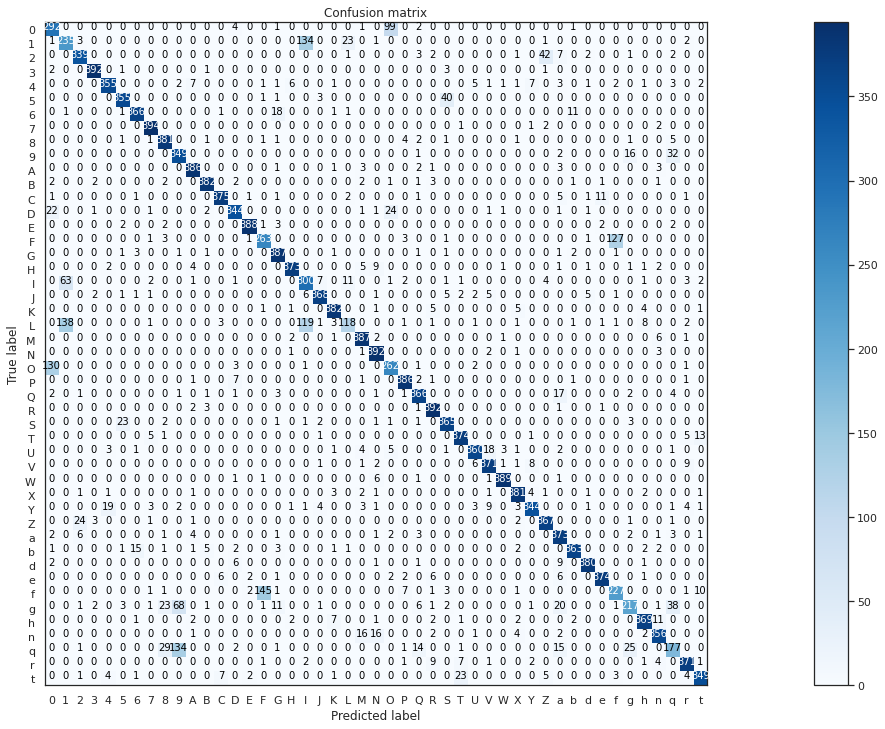

In [ ]:
Y_pred = model.predict(X_test) # prevendo os valores do conjunto de dados de validação
Y_pred_classes = np.argmax(Y_pred,axis=1)
Y_true = np.argmax(Y_test,axis=1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) #calculando a matriz de confusão
plot_confusion_matrix(confusion_mtx, classes=range(47)) #mostrando a matriz de confusão

In [ ]:
print(classification_report(Y_true, Y_pred_classes, target_names='0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt'))

              precision    recall  f1-score   support

           0       0.64      0.73      0.68       400
           1       0.54      0.59      0.56       400
           2       0.90      0.85      0.87       400
           3       0.98      0.98      0.98       400
           4       0.92      0.89      0.91       400
           5       0.91      0.89      0.90       400
           6       0.94      0.92      0.93       400
           7       0.96      0.98      0.97       400
           8       0.85      0.95      0.90       400
           9       0.63      0.87      0.73       400
           A       0.94      0.96      0.95       400
           B       0.96      0.95      0.96       400
           C       0.96      0.94      0.95       400
           D       0.92      0.86      0.89       400
           E       0.98      0.97      0.97       400
           F       0.63      0.66      0.64       400
           G       0.89      0.97      0.93       400
           H       0.97    